# Planning course graded exercice

In this notebook we will consider a probabilistic maze problem defined as a Markov Decision Process [scikit-decide](https://github.com/airbus/scikit-decide) domain, where the controlled agent moving in the maze can magically teleport itself upon some events.
You will then solve the problem by using one of the probabilistic algorithms provided by `scikit-decide`.

First we need to select the right planning class in `scikit-decide`'s [domain class generator](https://airbus.github.io/scikit-decide/codegen/), i.e. `MPDDomain` which is additionnally `renderable` and have `goals`.
It will generate the following domain class template:

In [ ]:
from enum import Enum
from typing import *

from skdecide import *
from skdecide.builders.domain import *


# Example of State type (adapt to your needs)
class State(NamedTuple):
    x: int
    y: int


# Example of Action type (adapt to your needs)
class Action(Enum):
    up = 0
    down = 1
    left = 2
    right = 3


class D(MDPDomain, Renderable):
    T_state = State  # Type of states
    T_observation = T_state  # Type of observations
    T_event = Action  # Type of events
    T_value = float  # Type of transition values (rewards or costs)
    T_info = None  # Type of additional information in environment outcome


class MyDomain(D):
    
    def _is_terminal(self, state: D.T_state) -> D.T_predicate:
        pass
    
    def _get_transition_value(self, memory: D.T_state, action: D.T_event, next_state: Optional[D.T_state] = None) -> Value[D.T_value]:
        pass
    
    def _get_next_state_distribution(self, memory: D.T_state, action: D.T_event) -> SingleValueDistribution[D.T_state]:
        pass
    
    def _get_action_space_(self) -> Space[D.T_event]:
        pass
    
    def _get_applicable_actions_from(self, memory: D.T_state) -> Space[D.T_event]:
        pass
    
    def _get_goals_(self) -> Space[D.T_observation]:
        pass
    
    def _get_initial_state_(self) -> D.T_state:
        pass
    
    def _get_observation_space_(self) -> Space[D.T_observation]:
        pass
    
    def _render_from(self, memory: D.T_state, **kwargs: Any) -> Any:
        pass

Now, we implement a `TeleportationMazeDomain` class from this template.
We assume that whenever the agent attempts to go up, it will go back to its initial state with probability 0.9.
Every move costs 10 but 20 when we hit a wall or 1 when the agent goes through a "dollar" light green cell.
Therefore, the agent must find a compromise between going up in the middle of the maze to gather the dollars and not being teleported to the initial state.

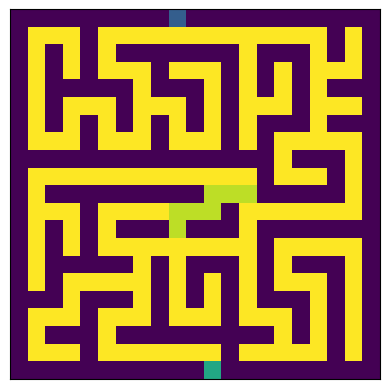

In [7]:
from enum import Enum
from typing import *
from copy import deepcopy

from skdecide import *
from skdecide.builders.domain import *
from skdecide.hub.space.gym import EnumSpace, ListSpace

# %matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


DEFAULT_MAZE = """
+-+-+-+-+o+-+-+-+-+-+
|   |             | |
+ + + +-+-+-+ +-+ + +
| | |   |   | | |   |
+ +-+-+ +-+ + + + +-+
| |   |   | |   |   |
+ + + + + + + +-+ +-+
|   |   |   | |     |
+-+-+-+-+-+-+-+ +-+ +
|             |   | |
+ +-+-+-+-+$$$+-+-+ +
|   |    $$$|       |
+ + + +-+$+-+ +-+-+-+
| | |         |     |
+ +-+-+ + +-+ + +-+ +
| |     | | | |   | |
+-+ +-+ + + + +-+ + +
|   |   |   |   | | |
+ +-+ +-+-+-+-+ + + +
|   |       |     | |
+-+-+-+-+-+x+-+-+-+-+
"""


# Example of State type (adapt to your needs)
class State(NamedTuple):
    x: int
    y: int


# Example of Action type (adapt to your needs)
class Action(Enum):
    up = 0
    down = 1
    left = 2
    right = 3


class D(MDPDomain, Goals, Renderable):
    T_state = State  # Type of states
    T_observation = T_state  # Type of observations
    T_event = Action  # Type of events
    T_value = float  # Type of transition values (rewards or costs)
    T_info = None  # Type of additional information in environment outcome


class TeleportationMazeDomain(D):
    
    def __init__(self, maze_str: str = DEFAULT_MAZE, dollar_cost=1.0, dollar_probability=0.9):
        maze = []
        self._dollars = []
        for y, line in enumerate(maze_str.strip().split("\n")):
            line = line.rstrip()
            row = []
            for x, c in enumerate(line):
                if c in {" ", "o", "x", "$"}:
                    row.append(1)  # spaces are 1s
                    if c == "o":
                        self._start = State(x, y)
                    if c == "x":
                        self._goal = State(x, y)
                    if c == "$":
                        self._dollars.append(State(x, y))
                else:
                    row.append(0)  # walls are 0s
            maze.append(row)
        # self._render_maze = deepcopy(self._maze)
        self._maze = maze
        self._num_cols = len(maze[0])
        self._num_rows = len(maze)
        self._dollar_cost = dollar_cost
        self._dollar_probability = dollar_probability
        self._ax = None
        self._fig = None
        self._image = None
    
    def _is_terminal(self, state: D.T_state) -> D.T_predicate:
        return state == self._goal
    
    def _get_transition_value(self, memory: D.T_state, action: D.T_event, next_state: Optional[D.T_state] = None) -> Value[D.T_value]:
        ### WRITE YOUR CODE HERE
        pass
    
    def _get_next_state_distribution(self, memory: D.T_state, action: D.T_event) -> DiscreteDistribution[D.T_state]:
        ### WRITE YOUR CODE HERE
        pass
    
    def _get_action_space_(self) -> Space[D.T_event]:
        return EnumSpace(Action)
    
    def _get_applicable_actions_from(self, memory: D.T_state) -> Space[D.T_event]:
        if memory == self._goal:
            return ListSpace([Action.down])
        transitions = [
            (Action.left, State(memory.x - 1, memory.y)),
            (Action.right, State(memory.x + 1, memory.y)),
            (Action.up, State(memory.x, memory.y - 1)),
            (Action.down, State(memory.x, memory.y + 1))
        ]
        applicable_actions = []
        for tr in transitions:
            if (
                0 <= tr[1].x < self._num_cols
                and 0 <= tr[1].y < self._num_rows
                and self._maze[tr[1].y][tr[1].x] == 1
            ):
                applicable_actions.append(tr[0])
        assert len(applicable_actions) > 0
        return ListSpace(applicable_actions)
    
    def _get_goals_(self) -> Space[D.T_observation]:
        return ListSpace([self._goal])
    
    def _get_initial_state_(self) -> D.T_state:
        return self._start
    
    def _get_observation_space_(self) -> Space[D.T_observation]:
        pass
    
    def _render_from(self, memory: D.T_state, **kwargs: Any) -> Any:
        if self._ax is None:
            fig, ax = plt.subplots(1)
            #fig.canvas.set_window_title("Maze")
            ax.set_aspect("equal")  # set the x and y axes to the same scale
            plt.xticks([])  # remove the tick marks by setting to an empty list
            plt.yticks([])  # remove the tick marks by setting to an empty list
            ax.invert_yaxis()  # invert the y-axis so the first row of data is at the top
            self._ax = ax
            self._fig = fig
            plt.ion()
        maze = deepcopy(self._maze)
        for d in self._dollars:
            maze[d.y][d.x] = 0.9
        maze[self._goal.y][self._goal.x] = 0.6
        maze[memory.y][memory.x] = 0.3
        if 'path' in kwargs:
            for s in kwargs.get('path'):
                maze[s.y][s.x] = 0.5
        if self._image is None:
            self._image = self._ax.imshow(maze)
        else:
            self._image.set_data(maze)
        display(self._fig)
        clear_output(wait = True)
        plt.pause(0.001)
        
maze = TeleportationMazeDomain()
maze.render(maze._get_initial_state_())

Now, we solve the domain with the LRTDP solver, which is a famous extension of the LRTA* solver to solve Stochastic Shortest Path problems.

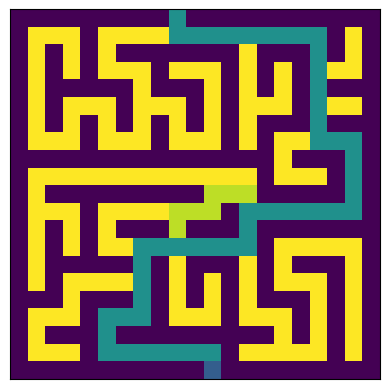

In [11]:
from skdecide.hub.solver.lrtdp import LRTDP
from skdecide.utils import rollout

from math import sqrt

domain_factory = lambda: TeleportationMazeDomain(maze_str=DEFAULT_MAZE, dollar_cost=1.0, dollar_probability=0.9)

solver_factory = lambda: LRTDP(
    domain_factory=domain_factory,
    heuristic=lambda d, s: Value(cost=sqrt((d._goal.x - s.x)**2 + (d._goal.y - s.y)**2)),
    discount=1.0,
    epsilon=0.001,
    parallel=False,
    debug_logs=False,
)

with solver_factory() as solver:
    TeleportationMazeDomain.solve_with(solver, domain_factory)
    
    plan = []
    cost = 0
    evaluation_domain = domain_factory()
    observation = evaluation_domain.reset()
    path = [observation]
    nb_steps = 0
    while (not evaluation_domain.is_goal(observation)) and nb_steps < 1000:
        plan.append(solver.sample_action(observation))
        outcome = evaluation_domain.step(plan[-1])
        cost += outcome.value.cost
        observation = outcome.observation
        path.append(observation)
        nb_steps += 1
        
    print(f'Found a plan of cost {cost}: {plan}')
    for i, s in enumerate(path):
        evaluation_domain.render(s, path=path[:i])

Now play with different `dollar_cost` and `dollar_probability` until finding a path that goes through the dollars in the maze.
Please comment your findings.

In [ ]:
### WRITE YOUR CODE HERE